### 사전 설정

In [ ]:
# 🔹 1. 나눔글꼴 설치 -> 이거 실행하고 런타임 초기화 한 이후에 아래 셀부터 다시 진행
!apt-get update -qq
!apt-get install -y fonts-nanum fonts-nanum-extra fonts-nanum-coding

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-extra
0 upgraded, 3 newly installed, 0 to remove and 36 not upgraded.
Need to get 31.4 MB of archives.
After this operation, 120 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-coding all 2.5-3 [4,988 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0 MB]
Fetched 31.4 MB in 2s (13.9 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126111 files and directories currently insta

In [ ]:
import os
import matplotlib as mpl

# 폰트 캐시 파일 제거
font_cache_dir = os.path.expanduser('~/.cache/matplotlib')
if os.path.exists(font_cache_dir):
    import shutil
    shutil.rmtree(font_cache_dir)
    print("폰트 캐시 삭제 완료")
else:
    print("폰트 캐시 없음")

폰트 캐시 삭제 완료


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

['NanumGothic']


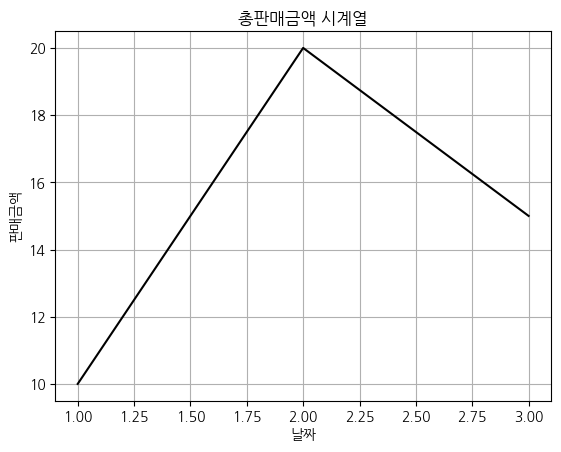

In [ ]:
print(mpl.rcParams['font.family'])

plt.plot([1, 2, 3], [10, 20, 15], color='black')
plt.title('총판매금액 시계열')  # <- 여기가 깨지면 폰트 설정 실패
plt.xlabel('날짜')
plt.ylabel('판매금액')
plt.grid(True)
plt.show()

### 데이터 불러오기 & 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

'''전처리 과정 참고 (생략)
file_path = '/content/drive/MyDrive/경경데/rawdata.csv'
sale = pd.read_csv(file_path, encoding = 'utf-8')

sale = sale[['회차','추첨일자','총판매금액','1등 당첨게임 수','1등 1게임당 당첨금액','이월여부', '4등 당첨게임 수', '5등 당첨게임 수']]
sale['fourth_fifth_num'] = sale['4등 당첨게임 수'] + sale['5등 당첨게임 수']
sale['fourth_fifth_num'] = sale['fourth_fifth_num'].astype(str).str.replace(',', '').astype(int)
sale['추첨일자'] = pd.to_datetime(sale['추첨일자'])
sale['1등 1게임당 당첨금액'] = sale['1등 1게임당 당첨금액'].astype(str).str.replace(',', '').astype(int)
sale = sale.sort_values(by='추첨일자')
sale.rename(columns = {"추첨일자": "date", "총판매금액":"total_sale","회차":"round","1등 당첨게임 수":"first_num","1등 1게임당 당첨금액":"first_amount","이월여부":"carry_over"}, inplace=True)'''


# 데이터 불러오기
rawdata = pd.read_csv('/content/drive/MyDrive/경경데/data/rawdata.csv', encoding = 'utf-8')
sale_df = pd.read_csv('/content/drive/MyDrive/경경데/data/final_cf_sales.csv')
economy_df = pd.read_csv("/content/drive/MyDrive/경경데/data/CCSI.csv", encoding = 'utf-8')

# 추가 전처리 (필요없는 컬럼 삭제 및 컬럼명 변경)
sale_df.drop(['cf_total_sale', '4등 당첨게임 수', '5등 당첨게임 수'], axis=1, inplace=True)
sale_df["log_cf_total_sale"] = np.log(sale_df['cf_total_sale_adjusted'])
sale_df.rename(columns= {'cf_total_sale_adjusted' : 'cf_total_sale'}, inplace=True)
print(sale_df.info())

# 날짜 형식 변환
rawdata['추첨일자'] = pd.to_datetime(rawdata['추첨일자'])
economy_df['date'] = pd.to_datetime(economy_df['date'], format='%Y/%m')
sale_df["date"] = pd.to_datetime(sale_df["date"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               911 non-null    object 
 1   round              911 non-null    float64
 2   total_sale         911 non-null    float64
 3   first_num          911 non-null    float64
 4   first_amount       911 non-null    int64  
 5   carry_over         911 non-null    float64
 6   fourth_fifth_num   911 non-null    int64  
 7   log_total_sale     911 non-null    float64
 8   cf_total_sale      911 non-null    float64
 9   log_cf_total_sale  911 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 71.3+ KB
None


In [ ]:
# 데이터 머지

# 1. datetime 형식으로 변환 (혹시 안됐을 경우 대비)
sale_df['date'] = pd.to_datetime(sale_df['date'])
economy_df['date'] = pd.to_datetime(economy_df['date'])

# 2. 'year-month' 단위로 통일 (sale_df에 'year_month' 컬럼 생성)
sale_df['year_month'] = sale_df['date'].dt.to_period('M').astype(str)
economy_df['year_month'] = economy_df['date'].dt.to_period('M').astype(str)

# 3. 머지 수행 (left join으로 sale_df 기준)
sale = sale_df.merge(economy_df[['year_month', 'CCSI']], on='year_month', how='left')

In [ ]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               911 non-null    datetime64[ns]
 1   round              911 non-null    float64       
 2   total_sale         911 non-null    float64       
 3   first_num          911 non-null    float64       
 4   first_amount       911 non-null    int64         
 5   carry_over         911 non-null    float64       
 6   fourth_fifth_num   911 non-null    int64         
 7   log_total_sale     911 non-null    float64       
 8   cf_total_sale      911 non-null    float64       
 9   log_cf_total_sale  911 non-null    float64       
 10  year_month         911 non-null    object        
 11  CCSI               882 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 85.5+ KB


In [ ]:
# 2008년부터의 데이터셋 (CCSI가 있는 경우만)
sale_copy = sale.copy()
sale_2008 = sale_copy[sale_copy['CCSI'].notnull()]
print(sale_2008.info())

<class 'pandas.core.frame.DataFrame'>
Index: 882 entries, 29 to 910
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               882 non-null    datetime64[ns]
 1   round              882 non-null    float64       
 2   total_sale         882 non-null    float64       
 3   first_num          882 non-null    float64       
 4   first_amount       882 non-null    int64         
 5   carry_over         882 non-null    float64       
 6   fourth_fifth_num   882 non-null    int64         
 7   log_total_sale     882 non-null    float64       
 8   cf_total_sale      882 non-null    float64       
 9   log_cf_total_sale  882 non-null    float64       
 10  year_month         882 non-null    object        
 11  CCSI               882 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 89.6+ KB
None


### 기본 시계열 차트

In [ ]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   연도            1173 non-null   int64         
 1   회차            1173 non-null   int64         
 2   추첨일자          1173 non-null   datetime64[ns]
 3   1등 당첨게임 수     1173 non-null   int64         
 4   1등 1게임당 당첨금액  1173 non-null   object        
 5   2등 당첨게임 수     1173 non-null   int64         
 6   2등 1게임당 당첨금액  1173 non-null   object        
 7   3등 당첨게임 수     1173 non-null   object        
 8   3등 1게임당 당첨금액  1173 non-null   object        
 9   4등 당첨게임 수     1173 non-null   object        
 10  4등 1게임당 당첨금액  1173 non-null   object        
 11  5등 당첨게임 수     1173 non-null   object        
 12  5등 1게임당 당첨금액  1173 non-null   object        
 13  1             1173 non-null   int64         
 14  2             1173 non-null   int64         
 15  3             1173 non-null   int64   

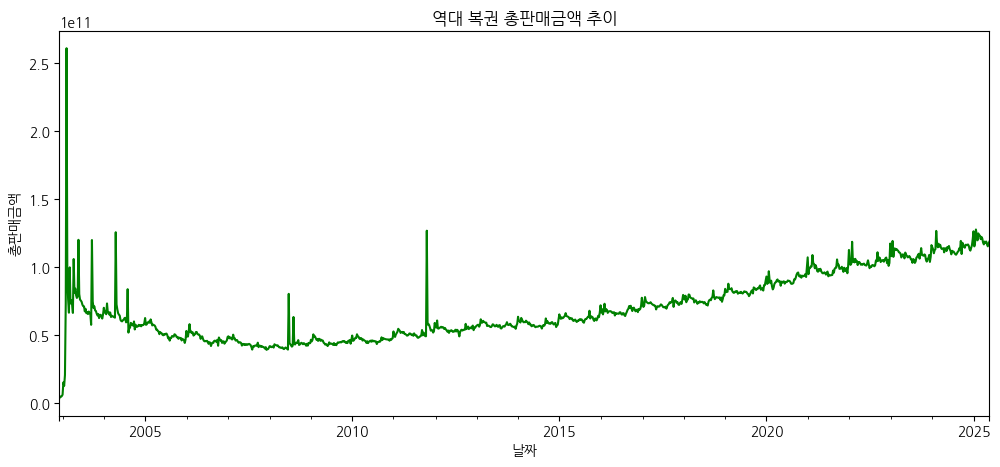

In [ ]:
# 시계열 플롯
rawdata = rawdata.set_index('추첨일자')
rawdata['총판매금액'].plot(title='역대 복권 총판매금액 추이', figsize=(12, 5), color = 'green')
plt.xlabel('날짜')
plt.ylabel('총판매금액')

# 저장
plt.savefig('/content/drive/MyDrive/경경데/역대 복권 총판매금액 추이(2002~).png', dpi=300, bbox_inches='tight')
plt.show()

Index(['date', 'round', 'total_sale', 'first_num', 'first_amount',
       'carry_over', 'fourth_fifth_num', 'log_total_sale', 'cf_total_sale',
       'log_cf_total_sale', 'year_month', 'CCSI'],
      dtype='object')


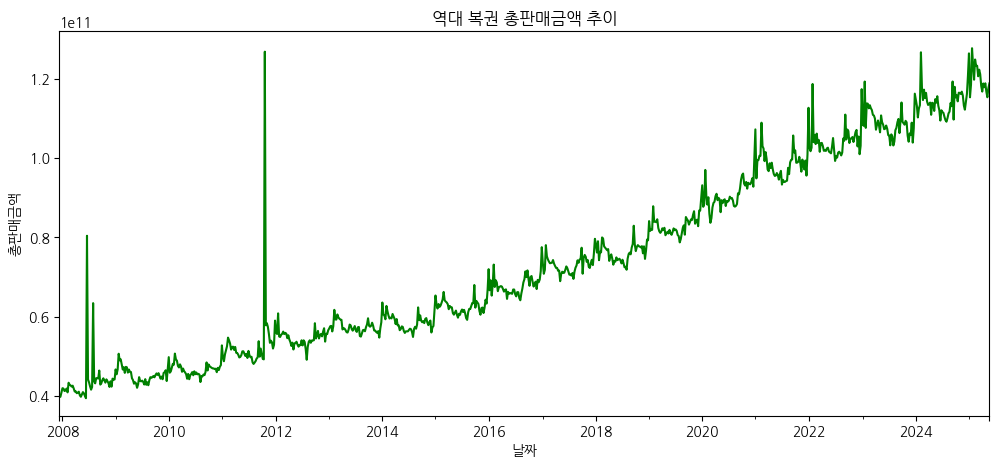

In [ ]:
# 시계열 플롯
print(sale.columns)
sale = sale.set_index('date')
sale['total_sale'].plot(title='역대 복권 총판매금액 추이', figsize=(12, 5), color = 'green')
plt.xlabel('날짜')
plt.ylabel('총판매금액')

# 저장
plt.savefig('/content/drive/MyDrive/경경데/역대 복권 총판매금액 추이_최종.png', dpi=300, bbox_inches='tight')
plt.show()

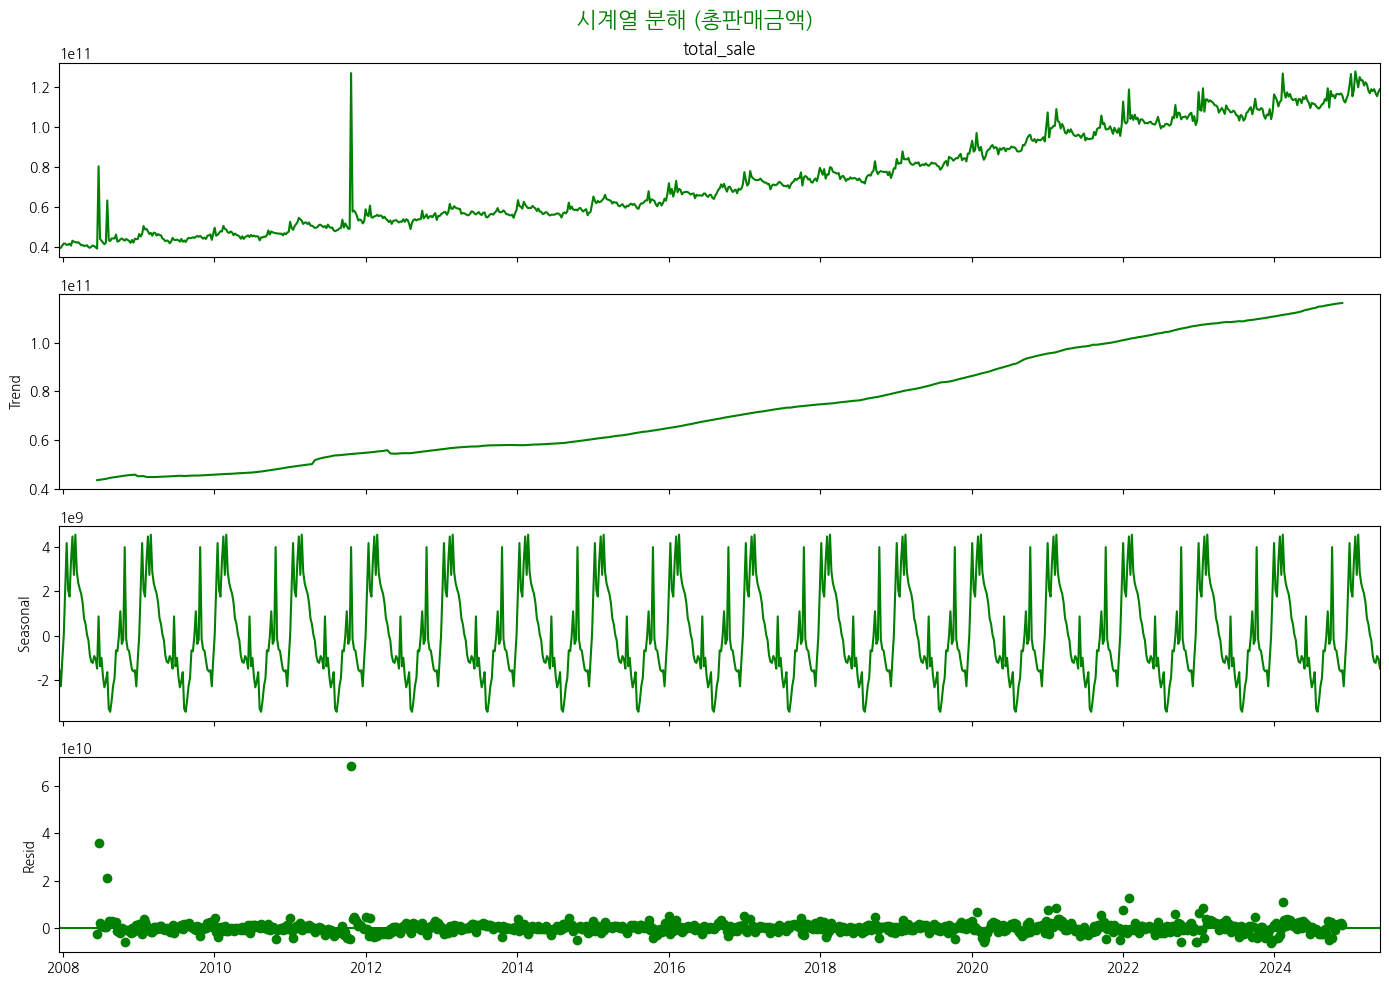

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np

# 시계열 분해 (주간 데이터 기준)
decomposition = seasonal_decompose(sale['total_sale'], model='additive', period=52)

# 시각화
fig = decomposition.plot()
fig.set_size_inches(14, 10)

# 각 서브플롯의 선을 초록색으로 설정
for ax in fig.axes:
    for line in ax.lines:
        line.set_color('green')

plt.suptitle('시계열 분해 (총판매금액)', fontsize=16, color='green')
plt.tight_layout()

# 저장
plt.savefig('/content/drive/MyDrive/경경데/시계열 분해_최종.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# trend 시계열에서 최솟값 위치
trend = decomposition.trend.dropna()  # NaN 제외 (양 끝에 존재할 수 있음)

# 최솟값 인덱스(날짜)와 값 출력
min_date = trend.idxmin()
min_value = trend.min()

print(f"✅ 추세 최솟값 시점: {min_date}")
print(f"📉 최소 추세값: {min_value:,.0f}")

✅ 추세 최솟값 시점: 26
📉 최소 추세값: 43,426,446,058


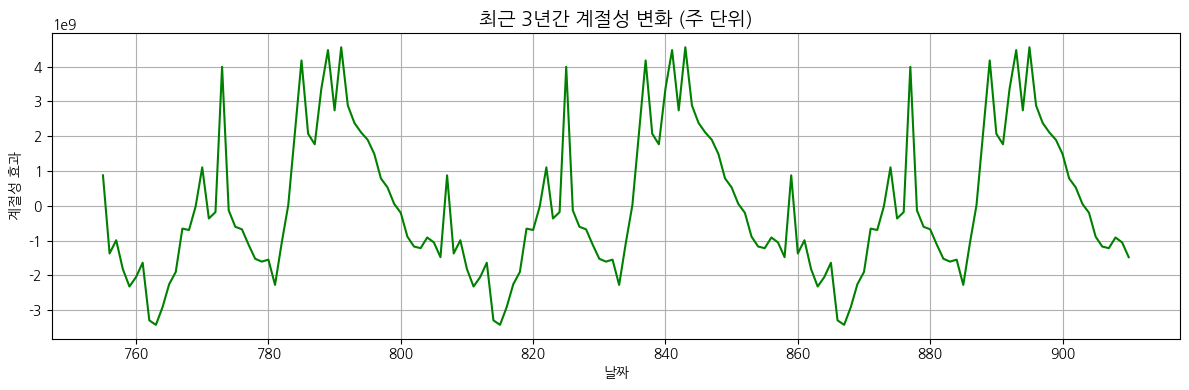

In [ ]:
# seasonal 성분만 추출
seasonal = decomposition.seasonal

# 최근 3~4년치만 확대해서 보기 (가독성 향상)
seasonal_tail = seasonal[-156:]  # 52주 * 3년

plt.figure(figsize=(12, 4))
plt.plot(seasonal_tail, color='green')
plt.title('최근 3년간 계절성 변화 (주 단위)', fontsize=14)
plt.xlabel('날짜')
plt.ylabel('계절성 효과')
plt.grid(True)
plt.tight_layout()

# 저장
plt.savefig('/content/drive/MyDrive/경경데/계절성_최근3년.png', dpi=300, bbox_inches='tight')
plt.show()

### 정상성 검정 + ACF,PACF 검정

In [ ]:
# ADF 검정
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(sale['total_sale'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 0.3566683399075325
p-value: 0.9798001346057171


In [ ]:
# p-value > 0.05 이므로 차분 필요
sale['diff'] = sale['total_sale'].diff()

# 5. ADF 테스트 다시
result_diff = adfuller(sale['diff'].dropna())
print(f'ADF Statistic after diff: {result_diff[0]}')
print(f'p-value: {result_diff[1]}')

ADF Statistic after diff: -11.622442623797424
p-value: 2.3666976242603027e-21


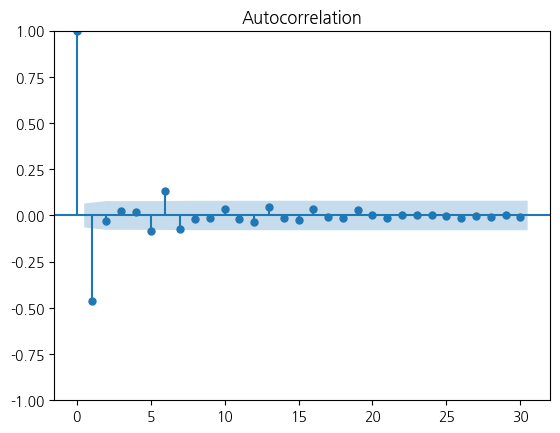

In [ ]:
# ACF,PACF를 통해 p,q 후보 추출
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(sale['diff'].dropna(), lags=30)

# 저장
plt.savefig('/content/drive/MyDrive/경경데/ACF.png', dpi=300, bbox_inches='tight')
plt.show()


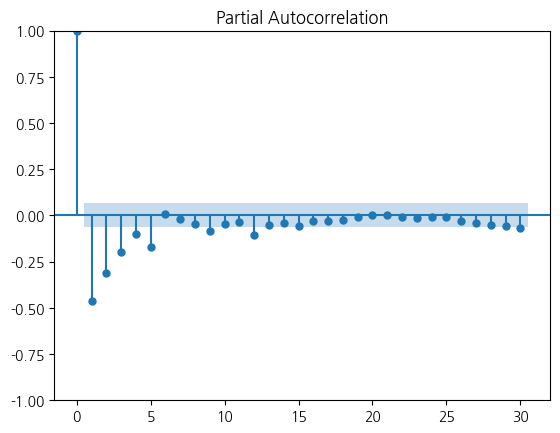

In [ ]:
#PACF를 통해 p,q 후보 추출

plot_pacf(sale['diff'].dropna(), lags=30)
# 저장
plt.savefig('/content/drive/MyDrive/경경데/PACF.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
sale.head()

,date,round,total_sale,first_num,first_amount,carry_over,fourth_fifth_num,log_total_sale,cf_total_sale,log_cf_total_sale,year_month,CCSI,diff
0,2007-12-15,263.0,3.967713e+10,6.0,1551704900,0.0,914793,24.404041,3.967713e+10,24.404041,2007-12,NaN,NaN
1,2007-12-22,264.0,3.978318e+10,7.0,1344889200,0.0,890339,24.406710,3.978318e+10,24.406710,2007-12,NaN,1.060500e+08
2,2007-12-29,265.0,4.091392e+10,8.0,1200838575,0.0,942122,24.434736,4.091392e+10,24.434736,2007-12,NaN,1.130744e+09
3,2008-01-05,266.0,4.193707e+10,3.0,3207211700,0.0,1045315,24.459436,4.193707e+10,24.459436,2008-01,NaN,1.023145e+09
4,2008-01-12,267.0,4.183585e+10,3.0,3257663300,0.0,981023,24.457020,4.183585e+10,24.457020,2008-01,NaN,-1.012140e+08


In [ ]:
# ARIMA 모델 상에서의 최적 p,q 추정
from statsmodels.tsa.arima.model import ARIMA

y = sale['total_sale'].dropna()

# y = sale['total_sale'].dropna()  # 결측값 제거

best_aic = float('inf')
best_order = None
best_model = None

for p in range(0, 6):
    for q in range(0, 3):
        try:
            model = ARIMA(y, order=(p, 1, q))
            result = model.fit()

            # 수렴 여부 확인
            if not result.mle_retvals.get('converged', False):
                print(f'❌ 수렴 실패: ARIMA({p},1,{q}) → AIC: {result.aic:.2f}')
                continue

            print(f'ARIMA({p},1,{q}) → AIC: {result.aic:.2f}, BIC: {result.bic:.2f}')

            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, 1, q)
                best_model = result

        except Exception as e:
            print(f'ARIMA({p},1,{q}) → 오류: {e}')

print(f"\n✅ 최적 모델: ARIMA{best_order} (AIC: {best_aic:.2f})")

ARIMA(0,1,0) → AIC: 43108.22, BIC: 43113.04
ARIMA(0,1,1) → AIC: 42772.48, BIC: 42782.11
ARIMA(0,1,2) → AIC: 42773.34, BIC: 42787.78
ARIMA(1,1,0) → AIC: 42908.63, BIC: 42918.26
ARIMA(1,1,1) → AIC: 42772.96, BIC: 42787.41
ARIMA(1,1,2) → AIC: 42775.34, BIC: 42794.59
ARIMA(2,1,0) → AIC: 42828.74, BIC: 42843.18
ARIMA(2,1,1) → AIC: 42774.97, BIC: 42794.22
ARIMA(2,1,2) → AIC: 42777.36, BIC: 42801.42
ARIMA(3,1,0) → AIC: 42800.74, BIC: 42820.00
ARIMA(3,1,1) → AIC: 42774.46, BIC: 42798.53
ARIMA(3,1,2) → AIC: 42773.59, BIC: 42802.48
ARIMA(4,1,0) → AIC: 42795.43, BIC: 42819.50
ARIMA(4,1,1) → AIC: 42773.82, BIC: 42802.70


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4,1,2) → AIC: 42772.62, BIC: 42806.31
ARIMA(5,1,0) → AIC: 42774.69, BIC: 42803.57
ARIMA(5,1,1) → AIC: 42776.39, BIC: 42810.09
ARIMA(5,1,2) → AIC: 42778.34, BIC: 42816.85

✅ 최적 모델: ARIMA(0, 1, 1) (AIC: 42772.48)


In [ ]:
# ARIMAX 모델 학습
model = ARIMA(y,order = (0,1,1))
result = model.fit()

# 결과 요약
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:             total_sale   No. Observations:                  911
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -21384.240
Date:                Thu, 05 Jun 2025   AIC                          42772.481
Time:                        12:12:34   BIC                          42782.108
Sample:                             0   HQIC                         42776.156
                                - 911                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7042      0.011    -62.581      0.000      -0.726      -0.682
sigma2      1.497e+19    1.8e-22    8.3e+40      0.000     1.5e+19     1.5e+19
Ljung-Box (L1) (Q):                   0.08   Jarque-

In [ ]:
#RMSE 계산코드

from sklearn.metrics import mean_squared_error
import numpy as np


# 예측값
y_pred = result.fittedvalues  # 또는 result.predict()

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

from sklearn.metrics import r2_score

r2 = r2_score(y, y_pred)
print("R² (설명력):", r2)

RMSE: 4106632613.7312565
R² (설명력): 0.9700797452509151


### 정상성 분석 (계절성)

In [ ]:
# seasonal 성분만 추출
seasonal = decomposition.seasonal

seasonal.head()

,seasonal
date,
2007-12-15,-1.547898e+09
2007-12-22,-2.273926e+09
2007-12-29,-1.075654e+09
2008-01-05,1.984466e+07
2008-01-12,2.091293e+09


In [ ]:
# ADF 검정
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(seasonal.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -8.91715943898066
p-value: 1.0650328489165697e-14


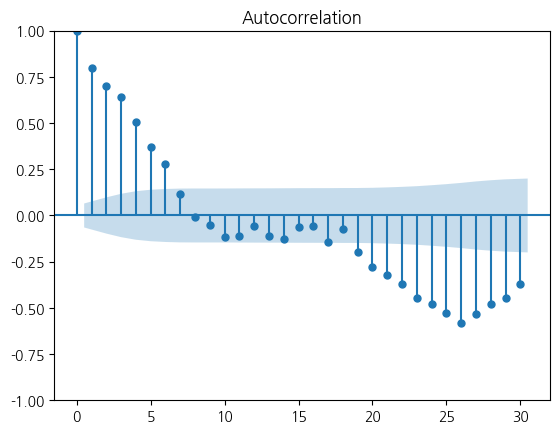

In [ ]:
# ACF,PACF를 통해 p,q 후보 추출
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(seasonal.dropna(), lags=30)

# 저장
# plt.savefig('/content/drive/MyDrive/경경데/ACF.png', dpi=300, bbox_inches='tight')
plt.show()


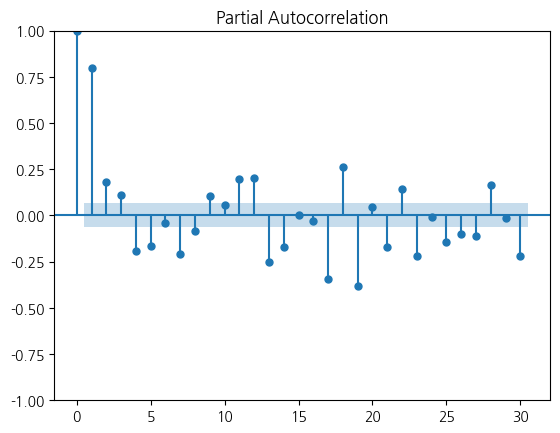

In [ ]:
#PACF를 통해 p,q 후보 추출

plot_pacf(seasonal.dropna(), lags=30)
# 저장
# plt.savefig('/content/drive/MyDrive/경경데/PACF.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def search_best_sarimax_with_seasonality(y, exog, d=1, D=0, s=52,
                                          max_p=4, max_q=1, max_P=2, max_Q=2):
    """
    외생변수를 포함한 SARIMAX 모델에서 계절성을 포함한 최적의 (p,d,q)x(P,D,Q,s) 조합을 탐색
    """
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    best_result = None

    for p in range(4,max_p + 1):
        for q in range(1,max_q + 1):
            for P in range(max_P + 1):
                for Q in range(max_Q + 1):
                    try:
                        model = SARIMAX(
                            y,
                            exog=exog,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, s),
                            enforce_stationarity=False,
                            enforce_invertibility=False
                        )
                        result = model.fit(disp=False)

                        if not result.mle_retvals.get("converged", False):
                            print(f"❌ 수렴 실패: order=({p},{d},{q}), seasonal=({P},{D},{Q},{s})")
                            continue

                        if result.aic < best_aic:
                            best_aic = result.aic
                            best_order = (p, d, q)
                            best_seasonal_order = (P, D, Q, s)
                            best_result = result

                    except Exception as e:
                        print(f"오류 발생: order=({p},{d},{q}), seasonal=({P},{D},{Q},{s}) → {e}")
                        continue

    if best_result is None:
        raise ValueError("수렴에 성공한 SARIMAX 모델이 없습니다.")

    return best_order, best_seasonal_order

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def search_best_sarimax_with_seasonality_2(y, d=1, D=0, s=52,
                                          max_p=4, max_q=2, max_P=2, max_Q=2):
    """
    외생변수를 포함한 SARIMAX 모델에서 계절성을 포함한 최적의 (p,d,q)x(P,D,Q,s) 조합을 탐색
    """
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    best_result = None

    total_combinations = (max_p + 1) * (max_q + 1) * (max_P + 1) * (max_Q + 1)
    progress = 0

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            for P in range(max_P + 1):
                for Q in range(max_Q + 1):
                    progress += 1
                    print(f"▶ 진행 중: {progress}/{total_combinations} → order=({p},{d},{q}), seasonal=({P},{D},{Q},{s})")

                    try:
                        model = SARIMAX(
                            y,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, s),
                            enforce_stationarity=False,
                            enforce_invertibility=False
                        )
                        result = model.fit(disp=False)

                        if not result.mle_retvals.get("converged", False):
                            print(f"❌ 수렴 실패: order=({p},{d},{q}), seasonal=({P},{D},{Q},{s})")
                            continue

                        if result.aic < best_aic:
                            best_aic = result.aic
                            best_order = (p, d, q)
                            best_seasonal_order = (P, D, Q, s)
                            best_result = result
                            print(f"✅ AIC 갱신: {best_aic:.2f} → order={best_order}, seasonal={best_seasonal_order}")

                    except Exception as e:
                        print(f"⚠️ 오류 발생: order=({p},{d},{q}), seasonal=({P},{D},{Q},{s}) → {e}")
                        continue

    if best_result is None:
        raise ValueError("수렴에 성공한 SARIMAX 모델이 없습니다.")

    return best_order, best_seasonal_order


In [ ]:
# 이월여부
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = sale['total_sale']

# 최적 (p,d,q) 찾기
best_order = search_best_sarimax_with_seasonality_2(y)

# ARIMAX 모델 학습
model = SARIMAX(y, order = best_order)
result = model.fit()

# 결과 요약
print(result.summary())

▶ 진행 중: 1/90 → order=(0,1,0), seasonal=(0,0,0,52)
✅ AIC 갱신: 43061.85 → order=(0, 1, 0), seasonal=(0, 0, 0, 52)
▶ 진행 중: 2/90 → order=(0,1,0), seasonal=(0,0,1,52)
✅ AIC 갱신: 40468.18 → order=(0, 1, 0), seasonal=(0, 0, 1, 52)
▶ 진행 중: 3/90 → order=(0,1,0), seasonal=(0,0,2,52)
✅ AIC 갱신: 38554.58 → order=(0, 1, 0), seasonal=(0, 0, 2, 52)
▶ 진행 중: 4/90 → order=(0,1,0), seasonal=(1,0,0,52)
▶ 진행 중: 5/90 → order=(0,1,0), seasonal=(1,0,1,52)
▶ 진행 중: 6/90 → order=(0,1,0), seasonal=(1,0,2,52)
▶ 진행 중: 7/90 → order=(0,1,0), seasonal=(2,0,0,52)
✅ AIC 갱신: 38100.16 → order=(0, 1, 0), seasonal=(2, 0, 0, 52)
▶ 진행 중: 8/90 → order=(0,1,0), seasonal=(2,0,1,52)
▶ 진행 중: 9/90 → order=(0,1,0), seasonal=(2,0,2,52)
▶ 진행 중: 10/90 → order=(0,1,1), seasonal=(0,0,0,52)
▶ 진행 중: 11/90 → order=(0,1,1), seasonal=(0,0,1,52)
▶ 진행 중: 12/90 → order=(0,1,1), seasonal=(0,0,2,52)
✅ AIC 갱신: 37677.95 → order=(0, 1, 1), seasonal=(0, 0, 2, 52)
▶ 진행 중: 13/90 → order=(0,1,1), seasonal=(1,0,0,52)
▶ 진행 중: 14/90 → order=(0,1,1), seasonal=(

ValueError: `order` argument must be an iterable with three elements.

In [ ]:
# 이월여부
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = sale['total_sale']

# 최적 (p,d,q) 찾기
# best_order = search_best_sarimax_with_seasonality_2(y)

# ARIMAX 모델 학습
model = SARIMAX(y, order = (4,1,1), seasonal_order = (2,0,1,52))
result = model.fit()

# 결과 요약
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         total_sale   No. Observations:                  911
Model:             SARIMAX(4, 1, 1)x(2, 0, 1, 52)   Log Likelihood              -21353.420
Date:                            Mon, 09 Jun 2025   AIC                          42724.839
Time:                                    12:35:32   BIC                          42768.160
Sample:                                         0   HQIC                         42741.379
                                            - 911                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1045      0.039      2.714      0.007       0.029       0.180
ar.L2          0.0361      0.039   

In [ ]:
#RMSE 계산코드

from sklearn.metrics import mean_squared_error
import numpy as np

# 평균 판매금액
mean_sale = model_df['total_sale'].mean()

# 예측값
y_pred = result.fittedvalues  # 또는 result.predict()

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("mean_total_sale:", mean_sale)
print("RMSE:", rmse)

from sklearn.metrics import r2_score

r2 = r2_score(y, y_pred)
print("R² (설명력):", r2)

mean_total_sale: 74766145709.75056
RMSE: 4015994409.699648
R² (설명력): 0.9713859203085891


### 최적 p,d,q 함수 설정

In [ ]:
# 최적 p,d,q 탐색 함수
def search_best_sarimax(y, exog, d=1, max_p=5, max_q=2):
    """
    외생변수(exog)를 포함한 SARIMAX 모델에서 수렴된 최적의 (p,d,q)를 탐색
    """
    best_aic = float('inf')
    best_order = None
    best_result = None

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = SARIMAX(y, exog=exog, order=(p, d, q))
                result = model.fit(disp=False)

                # ✅ 수렴하지 않은 모델은 무시
                if not result.mle_retvals.get("converged", False):
                    print(f"❌ 수렴 실패: ({p},{d},{q})")
                    continue

                # ✅ 수렴했으며 AIC가 가장 낮은 모델 선택
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, d, q)
                    best_result = result

            except Exception as e:
                print(f"오류 발생: ({p},{d},{q}) → {e}")
                continue

    if best_result is None:
        raise ValueError("수렴에 성공한 SARIMAX 모델이 없습니다.")

    return best_order

### 외생변수간 상관관계 확인

✅ y와 외생변수 간 상관계수:
fourth_fifth_num_lag1    0.972853
first_num_lag1           0.512917
first_amount_lag1       -0.041712
CCSI                    -0.249720
Name: log_cf_total_sale, dtype: float64


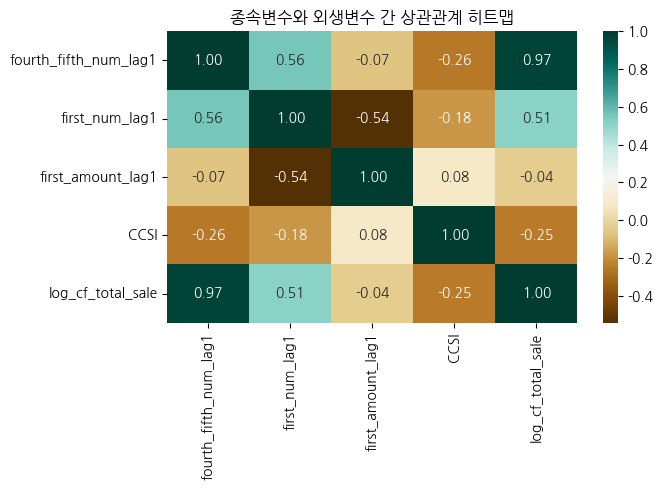

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 외생변수 및 종속변수 선택
X_cols = ['fourth_fifth_num_lag1', 'first_num_lag1', 'first_amount_lag1', 'CCSI']
y_col = 'log_cf_total_sale'

# X와 y 합치기
corr_df = sale[X_cols + [y_col]].dropna()  # 결측값 제거

# 상관계수 출력
correlations = corr_df.corr()[y_col].drop(y_col)
print("✅ y와 외생변수 간 상관계수:")
print(correlations.sort_values(ascending=False))

# 히트맵 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(corr_df.corr(), annot=True, cmap='BrBG', fmt=".2f")
plt.title("종속변수와 외생변수 간 상관관계 히트맵")
plt.tight_layout()



# 저장
plt.savefig('/content/drive/MyDrive/경경데/상관관계 히트맵.png', dpi=300, bbox_inches='tight')
plt.show()

### 판매금액 예측 모델 구현

In [ ]:
# 경제적 상황에 따른 판매효과
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

# 시점 변화
# 1. 전 회차의 1등 당첨자 수를 외생변수로 사용 (lag 처리)
sale['first_num_lag1'] = sale['first_num'].shift(1)
sale['first_amount_lag1'] =sale['first_amount'].shift(1)
sale['fourth_fifth_num_lag1'] = sale['fourth_fifth_num'].shift(1)

# 정규화
scaler = StandardScaler()
sale['CCSI_scaled'] = scaler.fit_transform(sale[['CCSI']])
sale['first_num_lag1_scaled'] = scaler.fit_transform(sale[['first_num_lag1']])
sale['first_amount_lag1_scaled'] = scaler.fit_transform(sale[['first_amount_lag1']])
sale['fourth_fifth_num_lag1_scaled'] = scaler.fit_transform(sale[['fourth_fifth_num_lag1']])

# 결측 제거 (첫 행 1개)
model_df = sale[['carry_over','round','total_sale','cf_total_sale','CCSI','CCSI_scaled','first_num_lag1','first_num_lag1_scaled','first_amount_lag1','first_amount_lag1_scaled','fourth_fifth_num_lag1','fourth_fifth_num_lag1_scaled']].dropna()

In [ ]:
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# X: 외생변수 DataFrame
# X = model_df[['carry_over','first_num_lag1','first_amount_lag1','fourth_fifth_num_lag1','CCSI']]
X = model_df[['carry_over','first_num_lag1_scaled','first_amount_lag1_scaled','fourth_fifth_num_lag1_scaled','CCSI_scaled']]
# X = model_df[['CCSI_scaled', 'first_num_lag1_scaled', 'fourth_fifth_num_lag1_scaled']]

# VIF 계산
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

                        feature       VIF
0                    carry_over  1.032281
1         first_num_lag1_scaled  2.342885
2      first_amount_lag1_scaled  1.633005
3  fourth_fifth_num_lag1_scaled  1.692596
4                   CCSI_scaled  1.077004


✅ y와 외생변수 간 상관계수:
fourth_fifth_num_lag1_scaled    0.973811
first_num_lag1_scaled           0.513470
carry_over                      0.041377
first_amount_lag1_scaled       -0.048988
CCSI_scaled                    -0.261511
Name: total_sale, dtype: float64


<ipython-input-14-5ba77869ce88>:35: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-5ba77869ce88>:35: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-5ba77869ce88>:35: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-5ba77869ce88>:35: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-5ba77869ce88>:35: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-5ba77869ce88>:35: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-5ba77869ce88>:35: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipy

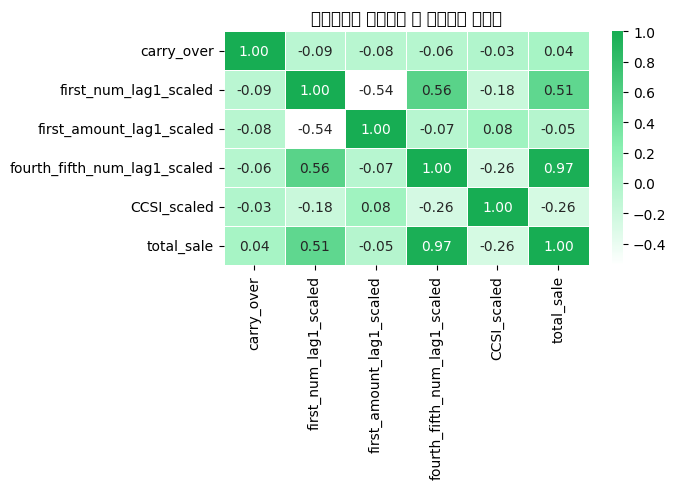

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 외생변수 및 종속변수 선택
X_cols = ['carry_over','first_num_lag1_scaled','first_amount_lag1_scaled','fourth_fifth_num_lag1_scaled','CCSI_scaled']
y_col = 'total_sale'

# X와 y 합치기
corr_df = sale[X_cols + [y_col]].dropna()  # 결측값 제거

# 상관계수 출력
correlations = corr_df.corr()[y_col].drop(y_col)
print("✅ y와 외생변수 간 상관계수:")
print(correlations.sort_values(ascending=False))

# 형광 초록 느낌의 컬러맵 정의 (흰색 → 형광 초록 → 검정)
neon_green_cmap = LinearSegmentedColormap.from_list(
    "neon_green",
    ["white",'#8af0b2',"#17AD53"]  # white → neon green → black
)

# 히트맵 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(
    corr_df.corr(),
    annot=True,
    cmap=neon_green_cmap,  # 초록색 계열의 색상맵
    fmt=".2f",
    linewidths=0.5,
    linecolor='white'
)
plt.title("종속변수와 외생변수 간 상관관계 히트맵")
plt.tight_layout()



# 저장
plt.savefig('/content/drive/MyDrive/경경데/상관관계 히트맵_수정.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ARIMAX 모델 학습
from statsmodels.tsa.statespace.sarimax import SARIMAX
#계절성 고려
# 종속변수와 외생변수 분리
y = model_df['total_sale']
X = model_df[['carry_over','first_num_lag1_scaled','first_amount_lag1_scaled','fourth_fifth_num_lag1_scaled','CCSI_scaled']]

# 최적 (p,d,q)와 (P,D,Q,s) 찾기
# best_order, best_seasonal_order = search_best_sarimax_with_seasonality(y, X)

# SARIMAX 모델 학습
model = SARIMAX(y, exog=X, order=(4,1,0), seasonal_order=(2,0,1,52))
result = model.fit()
print(result.summary())



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           total_sale   No. Observations:                  882
Model:             SARIMAX(4, 1, 0)x(2, 0, [1], 52)   Log Likelihood              -20330.257
Date:                              Mon, 09 Jun 2025   AIC                          40686.513
Time:                                      12:46:04   BIC                          40748.667
Sample:                                  07-05-2008   HQIC                         40710.281
                                       - 05-24-2025                                         
Covariance Type:                                opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
carry_over                     4.54e+10   2.19e-11   2.07e+21 

In [ ]:
# 종속변수와 외생변수 분리
y = model_df['total_sale']
X = model_df[['carry_over','first_num_lag1_scaled','first_amount_lag1_scaled','fourth_fifth_num_lag1_scaled','CCSI_scaled']]

# 최적 (p,d,q) 찾기
best_order = search_best_sarimax(y, X)

# ARIMAX 모델 학습
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y, exog=X, order=best_order)
result = model.fit()
print(result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  

                               SARIMAX Results                                
Dep. Variable:             total_sale   No. Observations:                  882
Model:               SARIMAX(4, 1, 0)   Log Likelihood              -20376.400
Date:                Thu, 05 Jun 2025   AIC                          40772.799
Time:                        08:12:46   BIC                          40820.610
Sample:                    07-05-2008   HQIC                         40791.082
                         - 05-24-2025                                         
Covariance Type:                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
carry_over                     4.54e+10   2.56e-13   1.78e+23      0.000    4.54e+10    4.54e+10
first_num_lag1_scaled         1.305e+08    6.6e-13   1.98e+20      0.000     

In [ ]:
#RMSE 계산코드

from sklearn.metrics import mean_squared_error
import numpy as np

# 평균 판매금액
mean_sale = model_df['total_sale'].mean()

# 예측값
y_pred = result.fittedvalues  # 또는 result.predict()

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("mean_total_sale:", mean_sale)
print("RMSE:", rmse)

from sklearn.metrics import r2_score

r2 = r2_score(y, y_pred)
print("R² (설명력):", r2)

mean_total_sale: 74766145709.75056
RMSE: 2859896135.07699
R² (설명력): 0.9850619544866486


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y, y_pred)
print("R² (설명력):", r2)

R² (설명력): 0.9850619544866486


### 동적 예측

In [ ]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 911 entries, 2007-12-15 to 2025-05-24
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   round              911 non-null    float64
 1   total_sale         911 non-null    float64
 2   first_num          911 non-null    float64
 3   first_amount       911 non-null    int64  
 4   carry_over         911 non-null    float64
 5   fourth_fifth_num   911 non-null    int64  
 6   log_total_sale     911 non-null    float64
 7   cf_total_sale      911 non-null    float64
 8   log_cf_total_sale  911 non-null    float64
 9   year_month         911 non-null    object 
 10  CCSI               882 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 85.4+ KB


In [ ]:
from datetime import timedelta

# 회차를 인덱스로 갖고 있다고 가정 (model_df.index 또는 model_df['round'])
# 또는 아래처럼 회차 정보가 있다면 직접 생성해도 됨
start_round = model_df['round'].min()
end_round = model_df['round'].max()

# 마지막 회차 날짜 (1173회차 = 2025-05-24)
last_round = 1173
last_round_date = pd.to_datetime('2025-05-24')

# 각 회차별 날짜 계산
model_df['draw_date'] = model_df['round'].apply(
    lambda x: last_round_date - timedelta(weeks=(last_round - x))
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 882 entries, 2008-07-05 to 2025-05-24
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   carry_over                    882 non-null    float64       
 1   round                         882 non-null    float64       
 2   total_sale                    882 non-null    float64       
 3   cf_total_sale                 882 non-null    float64       
 4   CCSI                          882 non-null    float64       
 5   CCSI_scaled                   882 non-null    float64       
 6   first_num_lag1                882 non-null    float64       
 7   first_num_lag1_scaled         882 non-null    float64       
 8   first_amount_lag1             882 non-null    float64       
 9   first_amount_lag1_scaled      882 non-null    float64       
 10  fourth_fifth_num_lag1         882 non-null    float64       
 11  fourth_fifth_

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           total_sale   No. Observations:                  882
Model:             SARIMAX(4, 1, 0)x(2, 0, [1], 52)   Log Likelihood              -17806.095
Date:                              Mon, 09 Jun 2025   AIC                          35638.189
Time:                                      13:01:35   BIC                          35698.643
Sample:                                  07-05-2008   HQIC                         35661.450
                                       - 05-24-2025                                         
Covariance Type:                                opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
carry_over                     4.54e+10    6.9e-12   6.58e+21 

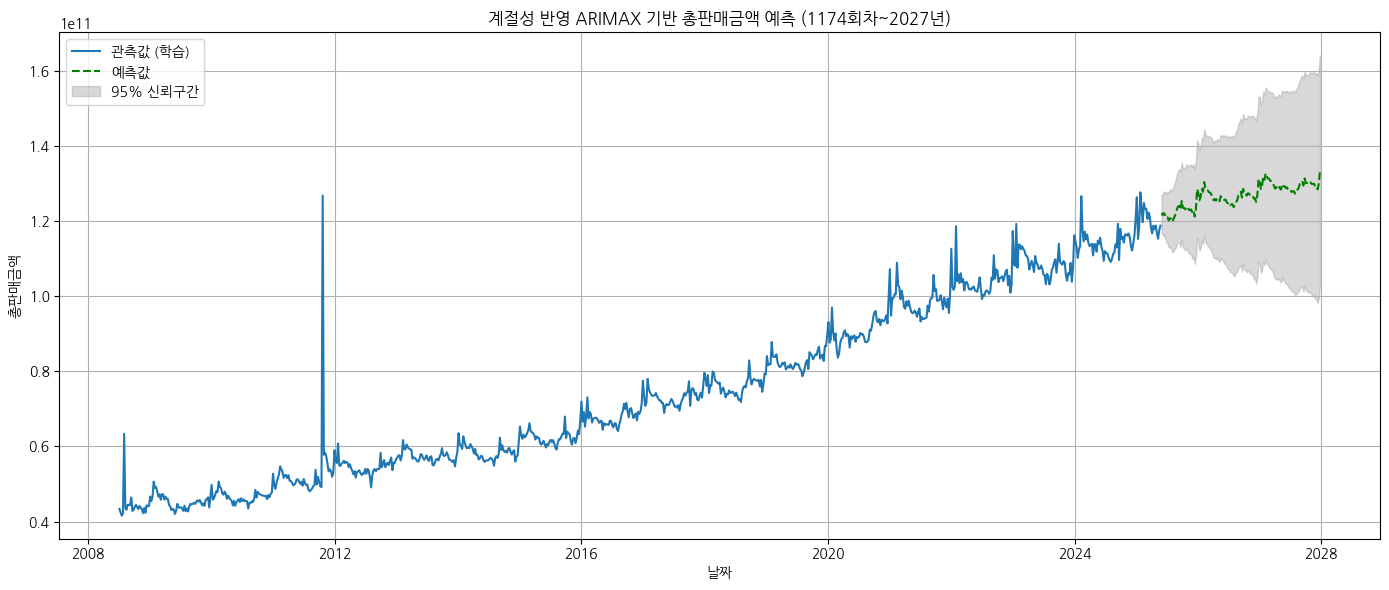

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# -------------------------
# 1. 데이터 준비
# -------------------------
# 종속변수와 외생변수 분리
y = model_df['total_sale']
X = model_df[['carry_over','first_num_lag1_scaled','first_amount_lag1_scaled','fourth_fifth_num_lag1_scaled','CCSI_scaled']]

model_df['round'] = sale['round']

print(model_df.info())
# 인덱스가 날짜여야 함 (주간 시계열)
model_df.index = pd.to_datetime(model_df['draw_date'])  # 'draw_date'는 추첨일자 컬럼
y.index = model_df.index
X.index = model_df.index

# -------------------------
# 2. SARIMAX 모델 학습 (계절성 포함)
# -------------------------
model = SARIMAX(
    y,
    exog=X,
    order=(4, 1, 0),
    seasonal_order=(2, 0, 1, 52),  # 52주 주기 계절성
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit()
print(result.summary())

# -------------------------
# 3. 미래 외생변수 생성 (1174회차 ~ 2027-12-31까지)
# -------------------------
last_date = pd.to_datetime("2025-05-24")
end_date = pd.to_datetime("2027-12-31")
n_periods = (end_date - last_date).days // 7

# 미래 날짜 생성
future_dates = [last_date + timedelta(weeks=i+1) for i in range(n_periods)]

# 외생변수 시나리오 (간단하게 평균값 사용)
X_future = pd.DataFrame({
    'CCSI_scaled': [X['CCSI_scaled'].mean()] * n_periods,
    'first_num_lag1_scaled': [X['first_num_lag1_scaled'].mean()] * n_periods,
    'first_amount_lag1_scaled': [X['first_amount_lag1_scaled'].mean()] * n_periods,
    'fourth_fifth_num_lag1_scaled': [X['fourth_fifth_num_lag1_scaled'].mean()] * n_periods,
    'carry_over': [X['carry_over'].mean()] * n_periods
}, index=future_dates)

# -------------------------
# 4. 예측 수행
# -------------------------
forecast_result = result.get_forecast(steps=n_periods, exog=X_future)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# -------------------------
# 5. 결과 정리
# -------------------------
forecast_df = pd.DataFrame({
    '회차': range(1174, 1174 + n_periods),
    '예측일': future_dates,
    '예측_총판매금액': forecast_mean.values,
    '신뢰구간_하한': forecast_ci.iloc[:, 0].values,
    '신뢰구간_상한': forecast_ci.iloc[:, 1].values
})

# -------------------------
# 6. 시각화
# -------------------------
plt.figure(figsize=(14,6))
plt.plot(y.index, y, label='관측값 (학습)')
plt.plot(forecast_df['예측일'], forecast_df['예측_총판매금액'], label='예측값', linestyle='--', color = 'green')
plt.fill_between(forecast_df['예측일'], forecast_df['신뢰구간_하한'], forecast_df['신뢰구간_상한'], color='gray', alpha=0.3, label='95% 신뢰구간')
plt.title('계절성 반영 ARIMAX 기반 총판매금액 예측 (1174회차~2027년)')
plt.xlabel('날짜')
plt.ylabel('총판매금액')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


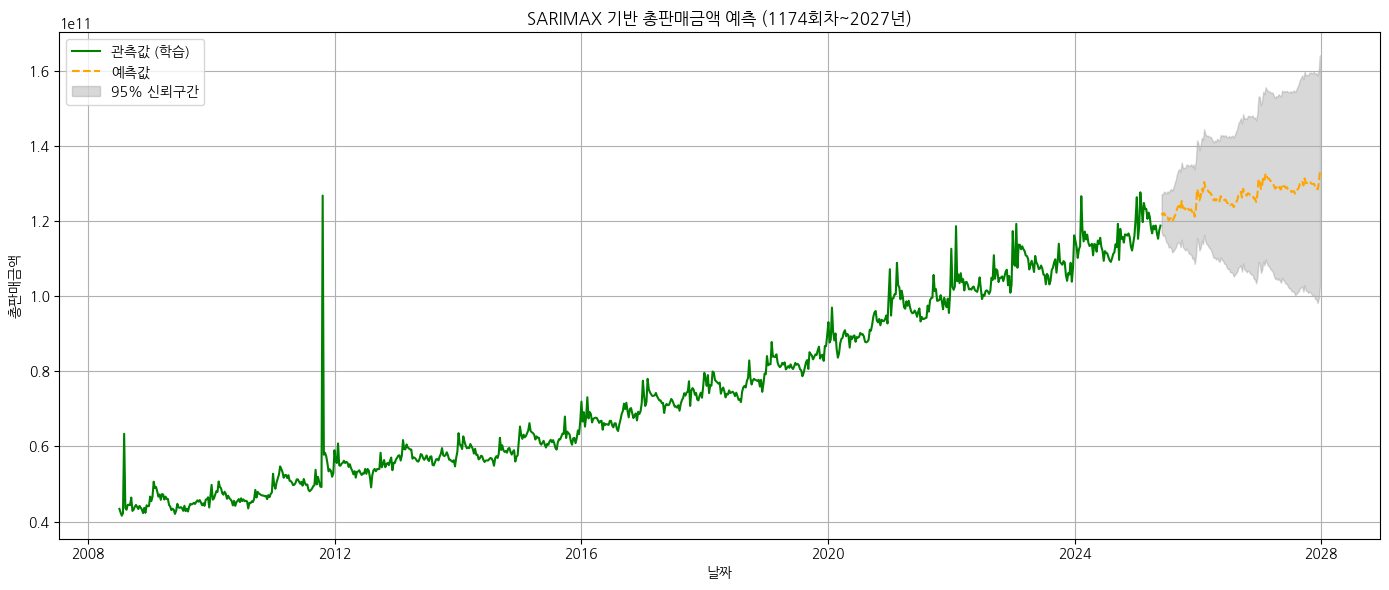

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y.index, y, label='관측값 (학습)', color='green')
plt.plot(forecast_df['예측일'], forecast_df['예측_총판매금액'], label='예측값', linestyle='--', color='orange')
plt.fill_between(forecast_df['예측일'], forecast_df['신뢰구간_하한'], forecast_df['신뢰구간_상한'], color='gray', alpha=0.3, label='95% 신뢰구간')
plt.title('SARIMAX 기반 총판매금액 예측 (1174회차~2027년)')
plt.xlabel('날짜')
plt.ylabel('총판매금액')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 저장
plt.savefig('/content/drive/MyDrive/경경데/시계열 예측_수정_최종.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
forecast_df.to_csv("/content/drive/MyDrive/경경데/예측금액_수정_최종.csv", encoding = 'utf-8')

### 예측 결과 분석

In [ ]:
import pandas as pd


# 1. 데이터 로딩
forecast_df.columns = [col.strip() for col in forecast_df.columns]
forecast_df['예측일'] = pd.to_datetime(forecast_df['예측일'], errors='coerce')

# 2. 반기별 필터 조건 정의
conditions = {
    '2025 하반기': (forecast_df['예측일'] >= '2025-07-01') & (forecast_df['예측일'] <= '2025-12-31'),
    '2026 상반기': (forecast_df['예측일'] >= '2026-01-01') & (forecast_df['예측일'] <= '2026-06-30'),
    '2026 하반기': (forecast_df['예측일'] >= '2026-07-01') & (forecast_df['예측일'] <= '2026-12-31'),
    '2027 상반기': (forecast_df['예측일'] >= '2027-01-01') & (forecast_df['예측일'] <= '2027-06-30'),
    '2027 하반기': (forecast_df['예측일'] >= '2027-07-01') & (forecast_df['예측일'] <= '2027-12-31'),
}

# 3. 총판매금액 및 정부 가용 예산 계산
total_sales_by_period = []
for period, cond in conditions.items():
    total = forecast_df.loc[cond, '예측_총판매금액'].sum()
    budget = total * 0.42
    total_sales_by_period.append({
        '기간': period,
        '총판매금액': total,
        '정부 가용 예산': budget
    })

# 4. 데이터프레임 생성
result_df = pd.DataFrame(total_sales_by_period)
result_df = result_df.set_index('기간')

# 5. 출력
print(result_df)

result_df.to_csv("/content/drive/MyDrive/경경데/정부가용예산_수정_최종.csv", encoding = 'utf-8')

                 총판매금액      정부 가용 예산
기간                                  
2025 하반기  3.190048e+12  1.339820e+12
2026 상반기  3.293624e+12  1.383322e+12
2026 하반기  3.284754e+12  1.379597e+12
2027 상반기  3.375162e+12  1.417568e+12
2027 하반기  3.366419e+12  1.413896e+12


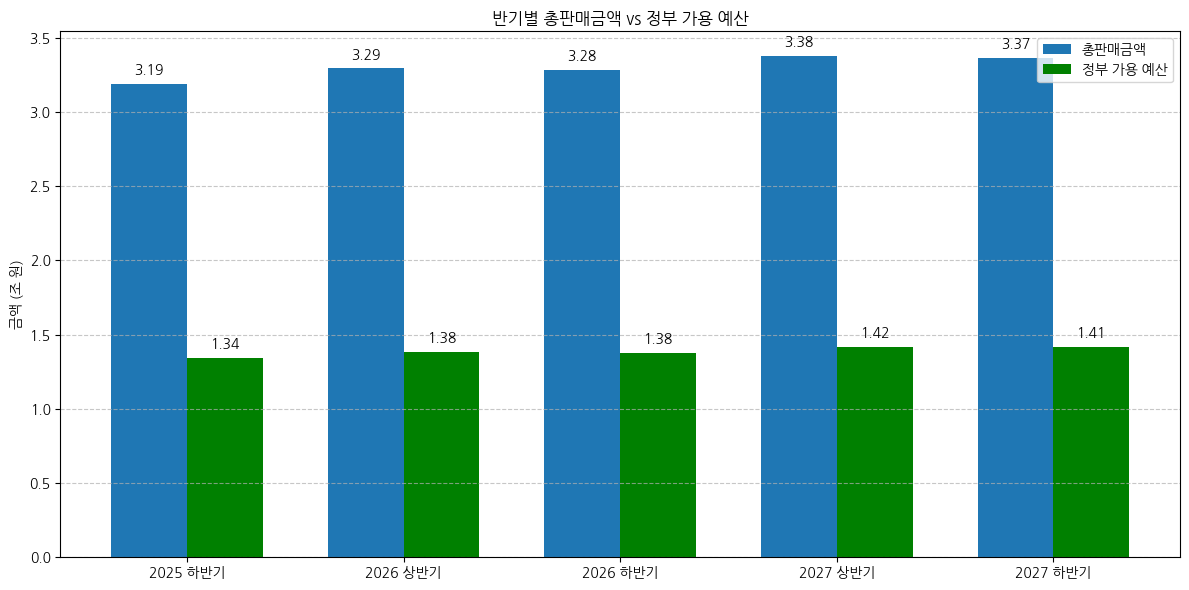

In [ ]:
# 시각화
import matplotlib.pyplot as plt
import numpy as np


# x축 라벨
labels = result_df.index.tolist()
x = np.arange(len(labels))  # x 좌표
width = 0.35  # 막대 너비

# 값
total_sales = result_df['총판매금액'].values
gov_budget = result_df['정부 가용 예산'].values

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width/2, total_sales / 1e12, width, label='총판매금액')
bar2 = ax.bar(x + width/2, gov_budget / 1e12, width, label='정부 가용 예산', color='green')

# 라벨 설정
ax.set_ylabel('금액 (조 원)')
ax.set_title('반기별 총판매금액 vs 정부 가용 예산')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# 바 위에 숫자 표시
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

plt.tight_layout()


# 저장
plt.savefig('/content/drive/MyDrive/경경데/정부예산_수정_최종.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# 1. sale 데이터 불러오기
sale_df = pd.read_csv('/content/drive/MyDrive/경경데/data/final_cf_sales.csv')
sale_df.drop(['cf_total_sale', '4등 당첨게임 수', '5등 당첨게임 수'], axis=1, inplace=True)
sale_df["log_cf_total_sale"] = np.log(sale_df['cf_total_sale_adjusted'])
sale_df.rename(columns= {'cf_total_sale_adjusted' : 'cf_total_sale'}, inplace=True)
sale_df["date"] = pd.to_datetime(sale_df["date"])

# 2. forecast 데이터 불러오기
forecast_df = pd.read_csv("/content/drive/MyDrive/경경데/예측금액_수정_최종.csv", encoding='utf-8')
forecast_df["예측일"] = pd.to_datetime(forecast_df["예측일"])

# 3. 2025년 상반기 실제 데이터
mask_sale = (sale_df['date'] >= '2025-01-01') & (sale_df['date'] <= '2025-05-24')
total_sale_early = sale_df.loc[mask_sale, 'cf_total_sale'].sum()

# 4. 2025년 하반기 예측 데이터
mask_forecast = (forecast_df['예측일'] >= '2025-05-25') & (forecast_df['예측일'] <= '2025-12-31')
total_sale_late = forecast_df.loc[mask_forecast, '예측_총판매금액'].sum()

# 5. 2025년 총합
total_2025 = total_sale_early + total_sale_late

# 정부기금
budget_2025 = total_2025 * 0.42

# 법정배분사업
law_budget_2025 = budget_2025 * 0.35

# 공익지원사업
public_budget_2025 = budget_2025 * 0.65

# 6. 출력
print(f"2025년 총 판매금액: {total_2025:,.0f} 원")
print(f"2025년 복권기금예산: {budget_2025:,.0f} 원")
print(f"2025년 법정배분예산: {law_budget_2025:,.0f} 원")
print(f"2025년 공익지원사업예산: {public_budget_2025:,.0f} 원")

2025년 총 판매금액: 6,322,823,598,605 원
2025년 복권기금예산: 2,655,585,911,414 원
2025년 법정배분예산: 929,455,068,995 원
2025년 공익지원사업예산: 1,726,130,842,419 원


In [ ]:
forecast_df.to_csv("/content/drive/MyDrive/경경데/forecast_df_2.csv",encoding='utf-8')

In [ ]:
# 2024년 총 판매금액 (정확히 1월 1일 ~ 12월 31일)
mask_2024 = (sale_df['date'] >= '2023-01-01') & (sale_df['date'] <= '2023-12-31')
total_2024 = sale_df.loc[mask_2024, 'cf_total_sale'].sum()

# 정부기금
budget_2024 = total_2024 * 0.42

# 법정배분사업
law_budget_2024 = budget_2024 * 0.35

# 공익지원사업
public_budget_2024 = budget_2024 * 0.65

# 출력
print(f"2024년 총 판매금액: {total_2024:,.0f} 원")
print(f"2024년 복권기금예산: {budget_2024:,.0f} 원")
print(f"2024년 법정배분예산: {law_budget_2024:,.0f} 원")
print(f"2024년 공익지원사업예산: {public_budget_2024:,.0f} 원")

2024년 총 판매금액: 5,648,581,000,000 원
2024년 복권기금예산: 2,372,404,020,000 원
2024년 법정배분예산: 830,341,407,000 원
2024년 공익지원사업예산: 1,542,062,613,000 원
